In [1]:
import gym
import numpy as np
import tensorflow as tf
import sklearn
import sklearn.preprocessing

record = []
for ii in range(10):
#     tf.reset_default_graph()
    tf.set_random_seed(1)
    tf.reset_default_graph()

    np.random.seed(1)
    env = gym.envs.make("MountainCarContinuous-v0") 
    env.seed(ii)
    
    input_dims = 2
    state_placeholder = tf.placeholder(tf.float32, [None, input_dims]) 

    def value_function(state):
        n_hidden1 = 400  
        n_hidden2 = 400
        n_outputs = 1

        with tf.variable_scope("value_network"):
            init_xavier = tf.contrib.layers.xavier_initializer()

            hidden1 = tf.layers.dense(state, n_hidden1, tf.nn.elu, 
                                      init_xavier)
            hidden2 = tf.layers.dense(hidden1, n_hidden2, tf.nn.elu, 
                                      init_xavier) 
            V = tf.layers.dense(hidden2, n_outputs, None, init_xavier)
        return V

    def policy_network(state):
        n_hidden1 = 40
        n_hidden2 = 40
        n_outputs = 1

        with tf.variable_scope("policy_network"):
            init_xavier = tf.contrib.layers.xavier_initializer()

            hidden1 = tf.layers.dense(state, n_hidden1, 
                                      tf.nn.elu, init_xavier)
            hidden2 = tf.layers.dense(hidden1, n_hidden2, 
                                      tf.nn.elu, init_xavier)
            mu = tf.layers.dense(hidden2, n_outputs, 
                                 None, init_xavier)
            sigma = tf.layers.dense(hidden2, n_outputs, 
                                    None, init_xavier)
            sigma = tf.nn.softplus(sigma) + 1e-5
            norm_dist = tf.contrib.distributions.Normal(mu, sigma)
            action_tf_var = tf.squeeze(norm_dist.sample(1), axis=0)
            action_tf_var = tf.clip_by_value(action_tf_var, 
                                             env.action_space.low[0], 
                                             env.action_space.high[0])
        return action_tf_var, norm_dist

    lr_actor = 0.00001  #set learning rates
    lr_critic = 0.00056

    #instantiate state-value function & policy network
    V = value_function(state_placeholder)
    action_tf_var, norm_dist = policy_network(state_placeholder)

    # define required placeholders
    action_placeholder = tf.placeholder(tf.float32)
    delta_placeholder = tf.placeholder(tf.float32)
    target_placeholder = tf.placeholder(tf.float32)

    # define actor (policy) loss function
    loss_actor = -tf.log(norm_dist.prob(action_placeholder) 
                         + 1e-5) * delta_placeholder
    training_op_actor = tf.train.AdamOptimizer(
             lr_actor, name='actor_optimizer').minimize(loss_actor)
    # define critic (state-value) loss function
    loss_critic = tf.reduce_mean(tf.squared_difference(
                                 tf.squeeze(V), target_placeholder))
    training_op_critic = tf.train.AdamOptimizer(
            lr_critic, name='critic_optimizer').minimize(loss_critic)


    state_space_samples = np.array(
        [env.observation_space.sample() for x in range(10000)])
    scaler = sklearn.preprocessing.StandardScaler()
    scaler.fit(state_space_samples)

    #function to normalize states
    def scale_state(state):                  #requires input shape=(2,)
        scaled = scaler.transform([state])
        return scaled                        #returns shape =(1,2)

    def phi(state, action):
        if state[1]*(action-1)>0:
            return 1
        else:
            return 0 

    gamma = 0.99        #discount factor
    num_episodes = 250
    advice = 1


    with tf.Session() as sess:        
        sess.run(tf.global_variables_initializer())
        episode_history = []
        for episode in range(num_episodes):
            #receive initial state from E
            state = env.reset()   # state.shape -> (2,)
#             print(state)
            state_p = state
            action_p = np.array([[0]])
            reward_total = 0
            steps = 0
            done = False
            while (not done):
                #Sample action according to current policy
                #action.shape = (1,1)
                action  = sess.run(action_tf_var, feed_dict={
                              state_placeholder: scale_state(state)})
                #Execute action and observe reward & next state from E
                # next_state shape=(2,)    
                #env.step() requires input shape = (1,)
                next_state, reward, done, _ = env.step(
                                        np.squeeze(action, axis=0))                                                                    
                steps +=1
                reward_total += reward

                if advice == 1:
                    reward = reward + phi(state,np.squeeze(action, axis=0)[0]) - phi(state_p,np.squeeze(action_p, axis=0)[0])/gamma

                #V_of_next_state.shape=(1,1)
                V_of_next_state = sess.run(V, feed_dict = 
                        {state_placeholder: scale_state(next_state)})  
                #Set TD Target
                #target = r + gamma * V(next_state)     
                if done:
                    target = reward
                else:
                    target = reward + gamma * np.squeeze(V_of_next_state) 


                # td_error = target - V(s)
                #needed to feed delta_placeholder in actor training
                td_error = target - np.squeeze(sess.run(V, feed_dict = 
                            {state_placeholder: scale_state(state)})) 

                if advice == 1:
                    td_error += phi(state_p,np.squeeze(action_p, axis=0)[0])/gamma 

                #Update actor by minimizing loss (Actor training)
                _, loss_actor_val  = sess.run(
                    [training_op_actor, loss_actor], 
                    feed_dict={action_placeholder: np.squeeze(action), 
                    state_placeholder: scale_state(state), 
                    delta_placeholder: td_error})
                #Update critic by minimizinf loss  (Critic training)
                _, loss_critic_val  = sess.run(
                    [training_op_critic, loss_critic], 
                    feed_dict={state_placeholder: scale_state(state), 
                    target_placeholder: target})

                action_p = action
                state_p = state
                state = next_state
                #end while
            print("Episode: {}, Steps in episode: {}, Cumulative reward: {}".format(episode, steps, reward_total))

#                 if np.mean(episode_history[-100:]) > 90 and len(episode_history) >= 101:
#                     print("****************Solved***************")
#                     print("Mean cumulative reward over last 100 episodes:", \
#                           np.mean(episode_history[-100:]))

            episode_history.append(reward_total)
    record.append(episode_history)
    print(ii, episode_history[-1])

Episode: 0, Steps in episode: 999, Cumulative reward: -40.35191167646048
Episode: 1, Steps in episode: 334, Cumulative reward: 86.12717257455817
Episode: 2, Steps in episode: 999, Cumulative reward: -35.496577663747246
Episode: 3, Steps in episode: 562, Cumulative reward: 79.60970077083554
Episode: 4, Steps in episode: 610, Cumulative reward: 77.2265668162494
Episode: 5, Steps in episode: 798, Cumulative reward: 71.14193128176723
Episode: 6, Steps in episode: 674, Cumulative reward: 75.71966037459454
Episode: 7, Steps in episode: 555, Cumulative reward: 79.52336598442771
Episode: 8, Steps in episode: 550, Cumulative reward: 81.06720511444207
Episode: 9, Steps in episode: 999, Cumulative reward: -33.36520843292692
Episode: 10, Steps in episode: 641, Cumulative reward: 77.58189024261716
Episode: 11, Steps in episode: 556, Cumulative reward: 79.14750860914705
Episode: 12, Steps in episode: 598, Cumulative reward: 80.68364337079848
Episode: 13, Steps in episode: 936, Cumulative reward: 68.

Episode: 113, Steps in episode: 143, Cumulative reward: 92.45808408390751
Episode: 114, Steps in episode: 195, Cumulative reward: 89.46262873950326
Episode: 115, Steps in episode: 142, Cumulative reward: 93.39744336525904
Episode: 116, Steps in episode: 113, Cumulative reward: 94.67161769736511
Episode: 117, Steps in episode: 183, Cumulative reward: 92.64582273111289
Episode: 118, Steps in episode: 214, Cumulative reward: 90.40002439223915
Episode: 119, Steps in episode: 152, Cumulative reward: 93.57368551169436
Episode: 120, Steps in episode: 181, Cumulative reward: 90.45432824572828
Episode: 121, Steps in episode: 189, Cumulative reward: 92.86729750523952
Episode: 122, Steps in episode: 209, Cumulative reward: 90.30209397546713
Episode: 123, Steps in episode: 112, Cumulative reward: 93.94763810704204
Episode: 124, Steps in episode: 141, Cumulative reward: 93.83479644812816
Episode: 125, Steps in episode: 147, Cumulative reward: 92.62872090234075
Episode: 126, Steps in episode: 176, C

Episode: 224, Steps in episode: 142, Cumulative reward: 92.50956585202631
Episode: 225, Steps in episode: 156, Cumulative reward: 94.38003703130114
Episode: 226, Steps in episode: 219, Cumulative reward: 89.29339731473699
Episode: 227, Steps in episode: 181, Cumulative reward: 92.29176892204094
Episode: 228, Steps in episode: 116, Cumulative reward: 94.68038136265807
Episode: 229, Steps in episode: 114, Cumulative reward: 93.61324409886647
Episode: 230, Steps in episode: 118, Cumulative reward: 93.99024721645239
Episode: 231, Steps in episode: 115, Cumulative reward: 94.02089671241878
Episode: 232, Steps in episode: 151, Cumulative reward: 93.53633107810403
Episode: 233, Steps in episode: 113, Cumulative reward: 93.22912562004804
Episode: 234, Steps in episode: 165, Cumulative reward: 94.12150660222305
Episode: 235, Steps in episode: 176, Cumulative reward: 91.29487839851083
Episode: 236, Steps in episode: 231, Cumulative reward: 91.27310857167423
Episode: 237, Steps in episode: 183, C

Episode: 85, Steps in episode: 187, Cumulative reward: 93.7547509572184
Episode: 86, Steps in episode: 191, Cumulative reward: 93.7761902799914
Episode: 87, Steps in episode: 185, Cumulative reward: 92.61392993557325
Episode: 88, Steps in episode: 339, Cumulative reward: 89.2657920381617
Episode: 89, Steps in episode: 310, Cumulative reward: 92.25595940980497
Episode: 90, Steps in episode: 190, Cumulative reward: 93.93041311958999
Episode: 91, Steps in episode: 186, Cumulative reward: 93.78138885435642
Episode: 92, Steps in episode: 267, Cumulative reward: 91.66878715500887
Episode: 93, Steps in episode: 389, Cumulative reward: 87.93375699253492
Episode: 94, Steps in episode: 152, Cumulative reward: 95.3511683004006
Episode: 95, Steps in episode: 232, Cumulative reward: 93.72298220507841
Episode: 96, Steps in episode: 216, Cumulative reward: 93.36248325090541
Episode: 97, Steps in episode: 185, Cumulative reward: 92.9132807516735
Episode: 98, Steps in episode: 228, Cumulative reward: 9

Episode: 197, Steps in episode: 186, Cumulative reward: 90.59520734821798
Episode: 198, Steps in episode: 146, Cumulative reward: 94.32169608818936
Episode: 199, Steps in episode: 184, Cumulative reward: 94.24328244343349
Episode: 200, Steps in episode: 114, Cumulative reward: 94.6601971183859
Episode: 201, Steps in episode: 112, Cumulative reward: 95.2137240638208
Episode: 202, Steps in episode: 151, Cumulative reward: 94.7173347135634
Episode: 203, Steps in episode: 193, Cumulative reward: 94.65428801740772
Episode: 204, Steps in episode: 118, Cumulative reward: 95.14056703448777
Episode: 205, Steps in episode: 153, Cumulative reward: 94.61537203235915
Episode: 206, Steps in episode: 187, Cumulative reward: 90.087435275981
Episode: 207, Steps in episode: 114, Cumulative reward: 95.54702657766751
Episode: 208, Steps in episode: 159, Cumulative reward: 94.76791069940444
Episode: 209, Steps in episode: 162, Cumulative reward: 93.28908464206819
Episode: 210, Steps in episode: 181, Cumula

Episode: 59, Steps in episode: 148, Cumulative reward: 92.10216606316466
Episode: 60, Steps in episode: 119, Cumulative reward: 94.81312962092703
Episode: 61, Steps in episode: 170, Cumulative reward: 91.03333834383187
Episode: 62, Steps in episode: 249, Cumulative reward: 89.9051168771911
Episode: 63, Steps in episode: 223, Cumulative reward: 89.76666881292628
Episode: 64, Steps in episode: 142, Cumulative reward: 92.35325126924194
Episode: 65, Steps in episode: 157, Cumulative reward: 94.5442036873274
Episode: 66, Steps in episode: 186, Cumulative reward: 91.73479473964653
Episode: 67, Steps in episode: 204, Cumulative reward: 91.73910390138445
Episode: 68, Steps in episode: 184, Cumulative reward: 90.04443733149402
Episode: 69, Steps in episode: 190, Cumulative reward: 90.78985257721152
Episode: 70, Steps in episode: 182, Cumulative reward: 92.27423746236332
Episode: 71, Steps in episode: 308, Cumulative reward: 86.43535888749064
Episode: 72, Steps in episode: 156, Cumulative reward

Episode: 171, Steps in episode: 110, Cumulative reward: 94.72788373007387
Episode: 172, Steps in episode: 116, Cumulative reward: 94.69674405752664
Episode: 173, Steps in episode: 191, Cumulative reward: 92.80918570050937
Episode: 174, Steps in episode: 140, Cumulative reward: 92.21886982859385
Episode: 175, Steps in episode: 150, Cumulative reward: 93.30943746176115
Episode: 176, Steps in episode: 112, Cumulative reward: 93.93167858960035
Episode: 177, Steps in episode: 146, Cumulative reward: 92.13016972239281
Episode: 178, Steps in episode: 185, Cumulative reward: 93.07138926268334
Episode: 179, Steps in episode: 111, Cumulative reward: 94.16071000153208
Episode: 180, Steps in episode: 142, Cumulative reward: 94.17826860478112
Episode: 181, Steps in episode: 123, Cumulative reward: 94.95668845703015
Episode: 182, Steps in episode: 159, Cumulative reward: 93.40155500325726
Episode: 183, Steps in episode: 114, Cumulative reward: 94.66631898591177
Episode: 184, Steps in episode: 180, C

Episode: 33, Steps in episode: 234, Cumulative reward: 90.95812797827274
Episode: 34, Steps in episode: 203, Cumulative reward: 93.29919132346734
Episode: 35, Steps in episode: 276, Cumulative reward: 90.51684726405226
Episode: 36, Steps in episode: 306, Cumulative reward: 88.78103259389606
Episode: 37, Steps in episode: 295, Cumulative reward: 89.95208365128234
Episode: 38, Steps in episode: 445, Cumulative reward: 85.85312739573115
Episode: 39, Steps in episode: 344, Cumulative reward: 88.23923861062308
Episode: 40, Steps in episode: 256, Cumulative reward: 90.11957494584667
Episode: 41, Steps in episode: 202, Cumulative reward: 92.86430665268554
Episode: 42, Steps in episode: 318, Cumulative reward: 88.94144869250297
Episode: 43, Steps in episode: 184, Cumulative reward: 92.64029562512852
Episode: 44, Steps in episode: 264, Cumulative reward: 89.24889696748006
Episode: 45, Steps in episode: 254, Cumulative reward: 90.87443421194202
Episode: 46, Steps in episode: 169, Cumulative rewa

Episode: 145, Steps in episode: 145, Cumulative reward: 92.11015035602891
Episode: 146, Steps in episode: 222, Cumulative reward: 89.72351054257035
Episode: 147, Steps in episode: 185, Cumulative reward: 93.29817707008968
Episode: 148, Steps in episode: 303, Cumulative reward: 87.46351917950199
Episode: 149, Steps in episode: 221, Cumulative reward: 90.3547606824633
Episode: 150, Steps in episode: 185, Cumulative reward: 93.76991357348503
Episode: 151, Steps in episode: 118, Cumulative reward: 95.07533201964907
Episode: 152, Steps in episode: 183, Cumulative reward: 90.2266867610556
Episode: 153, Steps in episode: 221, Cumulative reward: 91.66767938204316
Episode: 154, Steps in episode: 237, Cumulative reward: 91.55953154952914
Episode: 155, Steps in episode: 111, Cumulative reward: 94.80047740043739
Episode: 156, Steps in episode: 226, Cumulative reward: 92.69032445891884
Episode: 157, Steps in episode: 240, Cumulative reward: 88.61804117435258
Episode: 158, Steps in episode: 188, Cum

Episode: 6, Steps in episode: 999, Cumulative reward: -23.280162166767248
Episode: 7, Steps in episode: 999, Cumulative reward: -21.50096367261469
Episode: 8, Steps in episode: 999, Cumulative reward: -21.73285454304993
Episode: 9, Steps in episode: 999, Cumulative reward: -23.08557066180939
Episode: 10, Steps in episode: 999, Cumulative reward: -21.284102211207
Episode: 11, Steps in episode: 999, Cumulative reward: -20.890573231189407
Episode: 12, Steps in episode: 999, Cumulative reward: -19.176028578498872
Episode: 13, Steps in episode: 999, Cumulative reward: -17.163340263412206
Episode: 14, Steps in episode: 999, Cumulative reward: -18.018678416246306
Episode: 15, Steps in episode: 999, Cumulative reward: -18.609239177811094
Episode: 16, Steps in episode: 999, Cumulative reward: -19.722333353994973
Episode: 17, Steps in episode: 999, Cumulative reward: -18.855170198968565
Episode: 18, Steps in episode: 999, Cumulative reward: -16.95482189007069
Episode: 19, Steps in episode: 999, 

Episode: 118, Steps in episode: 290, Cumulative reward: 87.56592306063486
Episode: 119, Steps in episode: 182, Cumulative reward: 93.10796283686501
Episode: 120, Steps in episode: 284, Cumulative reward: 89.07633681552889
Episode: 121, Steps in episode: 180, Cumulative reward: 93.01888253985655
Episode: 122, Steps in episode: 270, Cumulative reward: 89.55744536074603
Episode: 123, Steps in episode: 114, Cumulative reward: 94.8782765404035
Episode: 124, Steps in episode: 164, Cumulative reward: 94.3374777561986
Episode: 125, Steps in episode: 288, Cumulative reward: 88.19743978126382
Episode: 126, Steps in episode: 175, Cumulative reward: 90.67095848076552
Episode: 127, Steps in episode: 188, Cumulative reward: 89.4614049438568
Episode: 128, Steps in episode: 210, Cumulative reward: 91.71777520560255
Episode: 129, Steps in episode: 215, Cumulative reward: 90.83018739041955
Episode: 130, Steps in episode: 216, Cumulative reward: 89.57282628847096
Episode: 131, Steps in episode: 180, Cumu

Episode: 229, Steps in episode: 237, Cumulative reward: 91.67563009946167
Episode: 230, Steps in episode: 177, Cumulative reward: 91.65922593404235
Episode: 231, Steps in episode: 188, Cumulative reward: 91.65559619660539
Episode: 232, Steps in episode: 179, Cumulative reward: 90.70062595974036
Episode: 233, Steps in episode: 112, Cumulative reward: 95.45386294600996
Episode: 234, Steps in episode: 177, Cumulative reward: 92.49924411813294
Episode: 235, Steps in episode: 147, Cumulative reward: 94.1150273906405
Episode: 236, Steps in episode: 179, Cumulative reward: 92.52746306824181
Episode: 237, Steps in episode: 149, Cumulative reward: 94.79133850352882
Episode: 238, Steps in episode: 238, Cumulative reward: 91.55692433315662
Episode: 239, Steps in episode: 240, Cumulative reward: 91.81580456961389
Episode: 240, Steps in episode: 224, Cumulative reward: 89.64885523985537
Episode: 241, Steps in episode: 116, Cumulative reward: 95.26395090524076
Episode: 242, Steps in episode: 178, Cu

Episode: 89, Steps in episode: 999, Cumulative reward: -20.874948138019047
Episode: 90, Steps in episode: 999, Cumulative reward: -17.685052662371813
Episode: 91, Steps in episode: 999, Cumulative reward: -15.321356670489845
Episode: 92, Steps in episode: 999, Cumulative reward: -14.976155301356755
Episode: 93, Steps in episode: 999, Cumulative reward: -12.523920725814177
Episode: 94, Steps in episode: 999, Cumulative reward: -15.900647281052523
Episode: 95, Steps in episode: 999, Cumulative reward: -14.902263029373342
Episode: 96, Steps in episode: 999, Cumulative reward: -15.280195850643398
Episode: 97, Steps in episode: 999, Cumulative reward: -12.866851998589098
Episode: 98, Steps in episode: 999, Cumulative reward: -15.004534414325459
Episode: 99, Steps in episode: 999, Cumulative reward: -15.37895379646243
Episode: 100, Steps in episode: 999, Cumulative reward: -15.915764140758158
Episode: 101, Steps in episode: 999, Cumulative reward: -16.754112517930647
Episode: 102, Steps in e

Episode: 198, Steps in episode: 999, Cumulative reward: -20.311029083092834
Episode: 199, Steps in episode: 949, Cumulative reward: 73.86000798499114
Episode: 200, Steps in episode: 999, Cumulative reward: -20.024991721553192
Episode: 201, Steps in episode: 908, Cumulative reward: 81.5887055886178
Episode: 202, Steps in episode: 840, Cumulative reward: 82.5166561544063
Episode: 203, Steps in episode: 998, Cumulative reward: 79.05109958334684
Episode: 204, Steps in episode: 953, Cumulative reward: 78.21149339259449
Episode: 205, Steps in episode: 999, Cumulative reward: -20.0463319331521
Episode: 206, Steps in episode: 999, Cumulative reward: -16.486555893797593
Episode: 207, Steps in episode: 842, Cumulative reward: 79.35312460463366
Episode: 208, Steps in episode: 551, Cumulative reward: 84.3168002589207
Episode: 209, Steps in episode: 680, Cumulative reward: 79.43373006929852
Episode: 210, Steps in episode: 999, Cumulative reward: -21.322786575452824
Episode: 211, Steps in episode: 6

Episode: 59, Steps in episode: 314, Cumulative reward: 90.26042422589411
Episode: 60, Steps in episode: 383, Cumulative reward: 89.66797518239112
Episode: 61, Steps in episode: 212, Cumulative reward: 93.55203868352038
Episode: 62, Steps in episode: 433, Cumulative reward: 87.56178978393686
Episode: 63, Steps in episode: 246, Cumulative reward: 93.19021273694318
Episode: 64, Steps in episode: 278, Cumulative reward: 90.31137213166087
Episode: 65, Steps in episode: 266, Cumulative reward: 91.73183434251231
Episode: 66, Steps in episode: 263, Cumulative reward: 91.69427650057636
Episode: 67, Steps in episode: 302, Cumulative reward: 91.5944423848307
Episode: 68, Steps in episode: 284, Cumulative reward: 88.6851014843937
Episode: 69, Steps in episode: 360, Cumulative reward: 90.55295908529624
Episode: 70, Steps in episode: 300, Cumulative reward: 91.52624551425879
Episode: 71, Steps in episode: 331, Cumulative reward: 91.48675050619238
Episode: 72, Steps in episode: 263, Cumulative reward

Episode: 171, Steps in episode: 230, Cumulative reward: 90.31006223540456
Episode: 172, Steps in episode: 241, Cumulative reward: 89.90765582482985
Episode: 173, Steps in episode: 267, Cumulative reward: 91.18349895294048
Episode: 174, Steps in episode: 198, Cumulative reward: 93.82886967242085
Episode: 175, Steps in episode: 155, Cumulative reward: 93.98216925085639
Episode: 176, Steps in episode: 178, Cumulative reward: 91.51275967300846
Episode: 177, Steps in episode: 199, Cumulative reward: 91.54288471959748
Episode: 178, Steps in episode: 253, Cumulative reward: 91.24605537454622
Episode: 179, Steps in episode: 177, Cumulative reward: 92.92643693986933
Episode: 180, Steps in episode: 202, Cumulative reward: 89.8616368376692
Episode: 181, Steps in episode: 203, Cumulative reward: 94.51019807862141
Episode: 182, Steps in episode: 190, Cumulative reward: 92.62456600258392
Episode: 183, Steps in episode: 194, Cumulative reward: 90.221323614808
Episode: 184, Steps in episode: 223, Cumu

Episode: 32, Steps in episode: 999, Cumulative reward: -14.960138154267609
Episode: 33, Steps in episode: 999, Cumulative reward: -16.49650813946713
Episode: 34, Steps in episode: 999, Cumulative reward: -15.00002895952702
Episode: 35, Steps in episode: 999, Cumulative reward: -15.078136749721613
Episode: 36, Steps in episode: 999, Cumulative reward: -15.423044767437307
Episode: 37, Steps in episode: 999, Cumulative reward: -17.40734390757214
Episode: 38, Steps in episode: 999, Cumulative reward: -14.395325796517982
Episode: 39, Steps in episode: 999, Cumulative reward: -14.619991922775128
Episode: 40, Steps in episode: 999, Cumulative reward: -15.769469718380355
Episode: 41, Steps in episode: 999, Cumulative reward: -14.199470114956442
Episode: 42, Steps in episode: 999, Cumulative reward: -12.876007462586715
Episode: 43, Steps in episode: 999, Cumulative reward: -15.022579101424004
Episode: 44, Steps in episode: 999, Cumulative reward: -19.412372709445144
Episode: 45, Steps in episod

Episode: 142, Steps in episode: 999, Cumulative reward: -11.967565184599732
Episode: 143, Steps in episode: 954, Cumulative reward: 88.23038614814858
Episode: 144, Steps in episode: 922, Cumulative reward: 90.7468117359108
Episode: 145, Steps in episode: 820, Cumulative reward: 87.93377611803827
Episode: 146, Steps in episode: 999, Cumulative reward: -10.110498964325716
Episode: 147, Steps in episode: 879, Cumulative reward: 89.99060082110158
Episode: 148, Steps in episode: 999, Cumulative reward: -14.221666995061545
Episode: 149, Steps in episode: 999, Cumulative reward: -12.08074512057643
Episode: 150, Steps in episode: 856, Cumulative reward: 87.94565668999124
Episode: 151, Steps in episode: 650, Cumulative reward: 91.58079858114351
Episode: 152, Steps in episode: 999, Cumulative reward: -12.751865688100423
Episode: 153, Steps in episode: 847, Cumulative reward: 87.86197394327601
Episode: 154, Steps in episode: 690, Cumulative reward: 90.37498864217497
Episode: 155, Steps in episode

Episode: 3, Steps in episode: 999, Cumulative reward: -27.788908982094334
Episode: 4, Steps in episode: 999, Cumulative reward: -26.30170866039713
Episode: 5, Steps in episode: 999, Cumulative reward: -27.111218711264332
Episode: 6, Steps in episode: 999, Cumulative reward: -26.84283750531879
Episode: 7, Steps in episode: 999, Cumulative reward: -25.756757586675022
Episode: 8, Steps in episode: 999, Cumulative reward: -24.977520111928918
Episode: 9, Steps in episode: 999, Cumulative reward: -26.63316352952597
Episode: 10, Steps in episode: 999, Cumulative reward: -21.879398393541386
Episode: 11, Steps in episode: 999, Cumulative reward: -21.803168579243096
Episode: 12, Steps in episode: 928, Cumulative reward: 75.53385076505207
Episode: 13, Steps in episode: 999, Cumulative reward: -26.025281654019604
Episode: 14, Steps in episode: 999, Cumulative reward: -25.479938852480764
Episode: 15, Steps in episode: 999, Cumulative reward: -25.547848759140965
Episode: 16, Steps in episode: 999, C

Episode: 115, Steps in episode: 153, Cumulative reward: 95.2197356140288
Episode: 116, Steps in episode: 219, Cumulative reward: 92.10752429316982
Episode: 117, Steps in episode: 184, Cumulative reward: 94.45542348679547
Episode: 118, Steps in episode: 283, Cumulative reward: 93.30883492866813
Episode: 119, Steps in episode: 183, Cumulative reward: 94.92781373516416
Episode: 120, Steps in episode: 184, Cumulative reward: 92.68044147832715
Episode: 121, Steps in episode: 260, Cumulative reward: 92.554809029705
Episode: 122, Steps in episode: 193, Cumulative reward: 93.84387539097756
Episode: 123, Steps in episode: 181, Cumulative reward: 93.59885548073453
Episode: 124, Steps in episode: 259, Cumulative reward: 92.58479802167524
Episode: 125, Steps in episode: 198, Cumulative reward: 90.1071907378979
Episode: 126, Steps in episode: 224, Cumulative reward: 93.25807843631408
Episode: 127, Steps in episode: 215, Cumulative reward: 91.57375259527456
Episode: 128, Steps in episode: 181, Cumul

Episode: 227, Steps in episode: 213, Cumulative reward: 93.95172989661368
Episode: 228, Steps in episode: 174, Cumulative reward: 93.97540997965876
Episode: 229, Steps in episode: 115, Cumulative reward: 95.37461307697592
Episode: 230, Steps in episode: 150, Cumulative reward: 94.98281889651446
Episode: 231, Steps in episode: 210, Cumulative reward: 92.42847891593038
Episode: 232, Steps in episode: 148, Cumulative reward: 94.69044103762434
Episode: 233, Steps in episode: 242, Cumulative reward: 91.53253194779052
Episode: 234, Steps in episode: 186, Cumulative reward: 92.8148067417284
Episode: 235, Steps in episode: 149, Cumulative reward: 94.36450643669534
Episode: 236, Steps in episode: 177, Cumulative reward: 91.65545067838676
Episode: 237, Steps in episode: 173, Cumulative reward: 93.09730296513692
Episode: 238, Steps in episode: 231, Cumulative reward: 90.44507012066056
Episode: 239, Steps in episode: 113, Cumulative reward: 95.4215164342896
Episode: 240, Steps in episode: 279, Cum

Episode: 89, Steps in episode: 115, Cumulative reward: 95.41620334741671
Episode: 90, Steps in episode: 209, Cumulative reward: 92.76545355118458
Episode: 91, Steps in episode: 177, Cumulative reward: 91.73321764059494
Episode: 92, Steps in episode: 241, Cumulative reward: 90.92258139810137
Episode: 93, Steps in episode: 177, Cumulative reward: 92.73713797411455
Episode: 94, Steps in episode: 226, Cumulative reward: 90.37980911720867
Episode: 95, Steps in episode: 152, Cumulative reward: 94.7868609971128
Episode: 96, Steps in episode: 214, Cumulative reward: 92.10769119434858
Episode: 97, Steps in episode: 192, Cumulative reward: 90.92838878134724
Episode: 98, Steps in episode: 222, Cumulative reward: 90.299312678528
Episode: 99, Steps in episode: 212, Cumulative reward: 93.05571183000164
Episode: 100, Steps in episode: 246, Cumulative reward: 93.01811553864307
Episode: 101, Steps in episode: 185, Cumulative reward: 92.72063007758577
Episode: 102, Steps in episode: 241, Cumulative rewa

Episode: 201, Steps in episode: 226, Cumulative reward: 89.22921295789214
Episode: 202, Steps in episode: 206, Cumulative reward: 92.72648239145352
Episode: 203, Steps in episode: 141, Cumulative reward: 93.22120801356833
Episode: 204, Steps in episode: 206, Cumulative reward: 90.8329001551662
Episode: 205, Steps in episode: 206, Cumulative reward: 88.91344481756848
Episode: 206, Steps in episode: 183, Cumulative reward: 91.55552045172841
Episode: 207, Steps in episode: 203, Cumulative reward: 91.23958916480825
Episode: 208, Steps in episode: 193, Cumulative reward: 92.96032064959255
Episode: 209, Steps in episode: 119, Cumulative reward: 95.55093226594558
Episode: 210, Steps in episode: 150, Cumulative reward: 93.34163096657409
Episode: 211, Steps in episode: 190, Cumulative reward: 94.35483942405692
Episode: 212, Steps in episode: 195, Cumulative reward: 89.98560646582727
Episode: 213, Steps in episode: 170, Cumulative reward: 92.39284885587892
Episode: 214, Steps in episode: 183, Cu

In [2]:
import csv
with open('Continuous_MC_w_b_advice', 'w', newline='') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    for ii in range(len(record)):
        wr.writerow(record[ii])

In [10]:
with open('Continuous_MC_w_b_advice', 'r') as myfile:
    rd = csv.reader(myfile)
    ep_reward_train_store = list(rd)
ep_reward_train_store = np.array(ep_reward_train_store, dtype=np.float32)

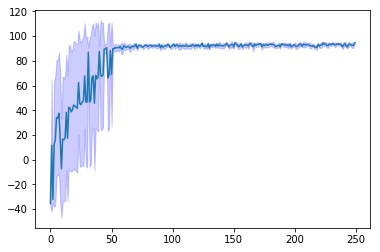

In [16]:
import matplotlib.pyplot as plt
# import seaborn as sns
x = np.arange(len(ep_reward_train_store[0]))

SAS_NonUniform_mean = np.mean(np.array(ep_reward_train_store[0:5]),axis=0)
SAS_NonUniform_std = np.std(np.array(ep_reward_train_store[0:5]),axis=0)
plt.plot(x, SAS_NonUniform_mean, label='SAS_NonUniform')
plt.fill_between(x, (SAS_NonUniform_mean-SAS_NonUniform_std), (SAS_NonUniform_mean+SAS_NonUniform_std), alpha=0.2,color='b')